# Matching truth to reco for tracks #

Plots investigating the truth to reco matches for the tracks

Nicole Hartman
June 2017


In [1]:
filepath  = '/atlas/local/BtagOptimizationNtuples/user.giacinto.mc16_13TeV.410501.PowhegPythia8EvtGen_A14_ttbar_hdamp258p75.BTagNtuples.May22.JetFitterStudies.v02_Akt4EMTo/user.giacinto.11401650.Akt4EMTo._000001.root'

In [2]:
import numpy as np
import pandas as pd

# matplotlib includes
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color map palatte
#matplotlib.rcParams.update({'font.size': 16})
from matplotlib.colors import LogNorm

# rootpy functions
from rootpy.vector import LorentzVector,Vector3
from rootpy.plotting import Hist,Hist2D
import rootpy.plotting.root2matplotlib as rplt

# useful functions that I've used in different notebooks stored in a single module
from dataHandling import root2pandas, flatten, flatten_trks
from prettyPlots  import plot_1D, plot_2D

# Get a df flatten for the jet level vars 

This is basically something similar to what I did for the truth, SV1, and JF dfs from the recoMassCorrections nb.


In [3]:
# Select the desired branches 
branches = ['jet_trk_algo','jet_trk_barcode','jet_trk_pdg_id',
               'jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_orig',
               'jet_bH_child_barcode','jet_bH_child_pdg_id',
               'jet_bH_child_px','jet_bH_child_py','jet_bH_child_pz',
               'jet_bH_nBtracks','jet_bH_nCtracks',
               'jet_LabDr_HadF','jet_pt'
              ]


# Convert the Ntuple to an nd array
df = root2pandas(filepath, 'bTag_AntiKt4EMTopoJets',branches=branches,start=50,stop=75)

# Flatten the array to jet level variables
df_flat = pd.DataFrame({k: flatten(c) for k, c in df.iteritems()})


# Only look at b-jets in this df
df_flat = df_flat[df_flat.jet_LabDr_HadF == 5]
df_flat.reset_index(inplace=True,drop=True)

##########################################################################################
#
# Add some new columns to correspond to the variables that I'm interested in looking at
#
##########################################################################################

# number truth tracks in the b-cascade 
df_flat['nBtrks'] = df_flat['jet_bH_nBtracks'] + df_flat['jet_bH_nCtracks']

# Reco trks found by JF
df_flat['trk_JF'] = pd.Series([[trk_alg >=16 for trk_alg in trk_algs ] for trk_algs in df_flat['jet_trk_algo']])
df_flat['ntrks_JF'] = pd.Series([sum(JFtrks) for JFtrks in df_flat['trk_JF']])

# Number of truth tracks JF also finds, identified by a barcode match
df_flat['ntrks_KEPT'] = pd.Series([sum([(reco_bcd in truth_bcds) and JF for reco_bcd, JF in zip(reco_bcds, JFs)]) \
                for _,(reco_bcds, JFs, truth_bcds) in df_flat[['jet_trk_barcode','trk_JF','jet_bH_child_barcode']].iterrows()])

# ID the number of times JF selects the wrong tracks
for origin,label in zip([-1,2,3],['PU','FRAG','GEANT']):
    df_flat['ntrks_{}'.format(label)] = pd.Series([sum([(orig == origin) and JF for reco_bcd, JF, orig in zip(reco_bcds, JFs, origs)]) \
                for _,(reco_bcds, JFs, origs) in df_flat[['jet_trk_barcode','trk_JF','jet_trk_orig']].iterrows()])

# Number of truth trks not reconstructed
df_flat['ntrks_LOST'] = pd.Series([sum([(truth_bcd not in reco_bcds) for truth_bcd in truth_bcds]) \
                for _,(reco_bcds, truth_bcds) in df_flat[['jet_trk_barcode','jet_bH_child_barcode']].iterrows()])

# Number of truth trks that JF fails to discover 
df_flat['ntrks_LOST_JF'] = pd.Series([sum([truth_bcd not in (reco_bcds & JFs) for truth_bcd in truth_bcds]) \
                for _,(reco_bcds, JFs, truth_bcds) in df_flat[['jet_trk_barcode','trk_JF','jet_bH_child_barcode']].iterrows()])

# reco tracks not selected by JF
# This number is expected to be high b/c there's a lot of other tracks in the jet not from the b
df_flat['RECOtrks_LOST_JF'] = pd.Series([sum([ not JF for JF in JFs]) for JFs in df_flat['trk_JF']])

# pT of truth tracks not in reco [MeV]
# df_flat['LOSTtrks_pT'] = 
# # pT of truth tracks not in JF
# df_flat['LOSTtrks_pT_JF'] = 
# # momentum of tracks not truth matched to the B-Cascade
# df_flat['?']

# reco tracks w/o a corresponding truth p'cle
df_flat['ntrks_recoMatchedToTruth'] = pd.Series([sum([(reco_bcd not in truth_bcds) for reco_bcd in reco_bcds]) \
                for _,(reco_bcds, truth_bcds) in df_flat[['jet_trk_barcode','jet_bH_child_barcode']].iterrows()])

    
# h_ntrks_recoMatchedToTruth = Hist(nbins,hmin,hmax) # reco tracks matched to truth
# h_ntrks_notFromCascade     = Hist(21,0,21) # tracks not from B-Cascade
# h_p_notFromCascade = Hist(20,0,8) # momentum of tracks not truth matched to the B-Cascade

# h_ntrks_JF    = Hist(nbins,hmin,hmax)  # Number of tracks from JF 
# h_ntrks_KEPT  = Hist(nbins,hmin,hmax)  # Number of truth tracks JF also finds
# h_ntrks_PU    = Hist(nbins,hmin,hmax)  # Number of trks from PU
# h_ntrks_FRAG  = Hist(nbins,hmin,hmax)  # Number of trks from fragmentation 
# h_ntrks_GEANT = Hist(nbins,hmin,hmax)  # Number of trks from detector affects

# h_ntrks_LOST     = Hist(nbins,hmin,hmax) # Number of truth trks not reconstructed
# h_ntrks_LOST_JF  = Hist(nbins,hmin,hmax) # Number of truth trks that JF fails to discover
# h_RECOtrks_LOST_JF  = Hist(nbins,hmin,hmax) # reco tracks lost by JF

# h_LOSTtrks_pT    = Hist(20,0,8) # pT of truth tracks not in reco [MeV]
# h_LOSTtrks_pT_JF = Hist(20,0,8) # pT of truth tracks not in JF

# h_ntrks_vs_jpt = Hist2D(25,0,125, 31,-0.5,30.5) # # of reco trks vs. b-jet pT
    

In [4]:
df_flat

,jet_LabDr_HadF,jet_bH_child_barcode,jet_bH_child_pdg_id,jet_bH_child_px,jet_bH_child_py,jet_bH_child_pz,jet_bH_nBtracks,jet_bH_nCtracks,jet_pt,jet_trk_algo,...,trk_JF,ntrks_JF,ntrks_KEPT,ntrks_PU,ntrks_FRAG,ntrks_GEANT,ntrks_LOST,ntrks_LOST_JF,RECOtrks_LOST_JF,ntrks_recoMatchedToTruth
0,5,"[10026, 10027, 10028, 10030, 10031, 10033, 100...","[-321, 211, 211, 211, -211, -211, 211, -211]","[-2288.03, -549.581, -1623.42, -1325.0, -2663....","[-3326.78, -1349.71, -5153.19, -1421.81, -4676...","[-692.153, -2.44498, -389.991, -5.56555, -661....",[5],[3],48863.175781,"[31, 3, 0, 0, 0, 31, 31, 0, 11, 31, 0, 0, 0, 0...",...,"[True, False, False, False, False, True, True,...",6,6,0,0,0,1,8,18,17
1,5,"[10011, 10023, 10024, 10025]","[211, 211, -211, -211]","[6376.76, 1454.13, 10601.8, 4279.54]","[-4537.51, -733.588, -5345.27, -1989.3]","[-27851.8, -6323.79, -40017.9, -13595.8]",[3],[1],69583.078125,"[0, 27, 11, 3, 0, 3, 16, 0, 0, 0, 0, 16, 3, 0, 3]",...,"[False, True, False, False, False, False, True...",3,1,1,1,0,0,4,12,11
2,5,"[10008, 10009, 10011, 10012, 10016, 10020]","[-321, 211, -211, 211, 211, -211]","[4472.0, 796.101, 1600.71, 1545.48, 860.828, 4...","[10283.7, 2750.82, 5220.42, 3836.16, 2333.5, 8...","[-35038.8, -8616.87, -16833.0, -13327.9, -7804...",[1],[5],71472.531250,"[19, 31, 0, 3, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, ...",...,"[True, True, False, False, False, False, False...",4,2,0,1,1,3,6,18,19
3,5,"[10037, 10040, 10041, 10045, 10047, 10052]","[-11, -211, 211, -211, 211, -211]","[-99.6107, -362.372, -1062.16, -1457.09, -538....","[-1868.61, -1166.03, -5996.15, -6023.8, -2092....","[122.416, 75.0104, 598.691, 516.261, 143.098, ...",[5],[1],58443.265625,"[31, 31, 31, 0, 0, 28, 28, 0, 3, 0, 0, 0, 0, 0...",...,"[True, True, True, False, False, True, True, F...",5,5,0,0,0,0,6,12,11
4,5,"[10055, 10056, 10058]","[211, -211, -13]","[-4366.21, -1653.15, -3449.64]","[-12116.3, -5388.63, -6151.84]","[6433.75, 3182.0, 4330.5]",[1],[2],67088.429688,"[31, 31, 0, 0, 0, 0, 31, 3, 3, 3, 0, 0]",...,"[True, True, False, False, False, False, True,...",3,3,0,0,0,0,3,9,9
5,5,"[10026, 10031, 10036, 10037, 10040]","[-321, 211, 211, -211, -211]","[7127.88, 654.003, 1411.69, 3112.42, 13717.6]","[4636.96, 666.719, 932.653, 2075.79, 9897.19]","[-2875.54, -325.919, -644.89, -1811.72, -8207.62]",[2],[3],44951.148438,"[31, 31, 31, 3, 0, 28, 0]",...,"[True, True, True, False, False, True, False]",4,4,0,0,0,1,5,3,3
6,5,"[10007, 10011, 10016, 10017]","[321, -211, 211, -211]","[-1280.68, -133.136, -282.35, -703.851]","[7187.78, 1097.78, 1221.33, 3908.75]","[-9868.49, -1756.55, -1476.08, -4233.67]",[1],[3],37947.078125,"[3, 3, 3, 0, 0, 3, 0, 3, 0, 0]",...,"[False, False, False, False, False, False, Fal...",0,0,0,0,0,1,4,10,7
7,5,"[10014, 10019, 10023, 10024, 10026, 10031, 100...","[321, -211, -211, 211, -211, 211, -211, 211]","[1958.44, 5786.29, 948.759, 2664.26, 506.96, 6...","[-1517.22, -4731.69, -703.378, -1834.0, -406.3...","[6518.04, 20842.5, 3060.4, 7740.85, 2289.51, 2...",[6],[2],51622.140625,"[0, 3, 0, 31, 31, 3, 11, 31, 31, 0, 16, 0, 0, ...",...,"[False, False, False, True, True, False, False...",5,5,0,0,0,2,8,13,12
8,5,"[10043, 10044, 10046, 10047, 10049]","[211, -211, 211, -321, -211]","[620.859, 899.816, 141.067, 1787.66, 501.502]","[-1269.52, -3290.85, -632.71, -4456.27, -624.374]","[-1823.02, -6489.37, -1069.19, -9854.81, -979....",[1],[4],34949.890625,"[16, 31, 31, 0, 28, 0, 0, 0, 0, 0, 0, 0]",...,"[True, True, True, False, True, False, False, ...",4,4,0,0,0,1,5,8,8
9,5,"[10019, 10021, 10025, 10026, 10027, 10028]","[-211, 211, 211, -211, -211, 211]","[-118.838, 105.124, -30.247, 249.758, -1830.73...","[-2350.42, -417.367, -795.196, -2377.23, -6353...","[4331.78, 493.898, 1425.02, 3965.67, 10386.5, ...",[4],[2],47189.250000,"[31, 31, 0, 3, 3, 3, 3, 3, 28, 0, 0, 0, 0, 3, ...",...,"[True, True, False, False, False, False, False...",7,5,1,1,0,1,6,18,20


In [5]:
df = root2pandas(filepath, 'bTag_AntiKt4EMTopoJets')

# Looking at the reco / truth particle matches#

(1) How many reco tracks are matched to truth tracks from the vertex 
    
    The branch jet_trk_jf_Vertex stores the INDEX of the vertex (from the intersections of the reco tracks with the bH flight path) that the track has a truth match to.

(What I thought this morning:
How I'm interpretting statement (1): How many reco / selected tracks are truth matched to coming from a vertex.   
So I think you could find this quantity by, for each jet, counting the number of tracks from a vertex with the same number.)

(2) How many other particles aren't matched to the vertex

# Looking at the tracks from JF

(3) In the collection of tracks from JF

    (a) How many tracks from the B+C cascade do we actually keep
        => The truth info should be in the bH_nChild
        
    (b) How many tracks from fragmentation + GEANT do we wrongly incorporate
    
    (c) How many track from the B+C decay do we lose
        (I wrote before that we might want to look up the track_to_vertex associators)

Next: Loop through all of the tracks, and select the ones that are included by JetFitter.

In [17]:
# Make histograms to store these quantities
hmin  = -0.5
hmax  = 10.5
nbins = int(hmax - hmin)

# The histograms are grouped in the order that I'm plotting them

h_ntrks_recoMatchedToTruth = Hist(nbins,hmin,hmax) # reco tracks matched to truth
h_ntrks_notFromCascade     = Hist(21,-0.5,20.5) # tracks not from B-Cascade
h_p_notFromCascade = Hist(20,0,8) # momentum of tracks not truth matched to the B-Cascade

h_ntrks_JF    = Hist(nbins,hmin,hmax)  # Number of tracks from JF 
h_ntrks_KEPT  = Hist(nbins,hmin,hmax)  # Number of truth tracks JF also finds
h_ntrks_PU    = Hist(nbins,hmin,hmax)  # Number of trks from PU
h_ntrks_FRAG  = Hist(nbins,hmin,hmax)  # Number of trks from fragmentation 
h_ntrks_GEANT = Hist(nbins,hmin,hmax)  # Number of trks from detector affects

h_ntrks_LOST     = Hist(nbins,hmin,hmax) # Number of truth trks not reconstructed
h_ntrks_LOST_JF  = Hist(nbins,hmin,hmax) # Number of truth trks that JF fails to discover
h_RECOtrks_LOST_JF  = Hist(nbins,hmin,hmax) # reco tracks lost by JF

h_LOSTtrks_pT    = Hist(20,0,8) # pT of truth tracks not in reco [MeV]
h_LOSTtrks_pT_JF = Hist(20,0,8) # pT of truth tracks not in JF

h_ntrks_vs_jpt = Hist2D(25,0,125, 31,-0.5,30.5) # # of reco trks vs. b-jet pT


In [18]:
# The first for loop iterates over the events
n_print = 1
orig = ["PU","b-had",'c-had','frag','GEANT']

# Count the # of trks barcode matched to truth IDed as PU
nPUtrksBarcodeMatched = 0
ntrksBarcodeMatched   = 0

for (_,(evt_algs,evt_trkBarcodes,evt_trkPDGs,evt_trkPt,evt_trkEta,evt_trkPhi,evt_trkOrigs,evt_childBarcodes,evt_childPDGs,evt_childPxs,evt_childPys,evt_childPzs,evt_jet_flav,evt_jet_pt)) in df[['jet_trk_algo','jet_trk_barcode','jet_trk_pdg_id','jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_orig','jet_bH_child_barcode','jet_bH_child_pdg_id','jet_bH_child_px','jet_bH_child_py','jet_bH_child_pz','jet_LabDr_HadF','jet_pt']].iterrows():

    # This loops over the jets in the evt
    for algs,trkBarcodes,trkPDGs,trkPts,trkEtas,trkPhis,trkOrigs,childBarcodes,childPDGs,childPxs,childPys,childPzs,jet_flav,jet_pt in zip(evt_algs,evt_trkBarcodes,evt_trkPDGs,evt_trkPt,evt_trkEta,evt_trkPhi,evt_trkOrigs,evt_childBarcodes,evt_childPDGs,evt_childPxs,evt_childPys,evt_childPzs,evt_jet_flav,evt_jet_pt):

        # Only look at the particles that have an associated b-hadron
        if jet_flav != 5:
            continue
        
        # Clear the variables / jet info that you have
        ntrks_recoMatchedToTruth = 0
        
        ntrks_notFromCascade = 0
        
        ntrks_JF    = 0  # Number of tracks from JF
        ntrks_KEPT  = 0  # truth tracks JF also finds
        ntrks_PU    = 0  # Number of JF trks from PU
        ntrks_FRAG  = 0  # Number of JF trks from fragmentation 
        ntrks_GEANT = 0  # Number of JF trks from detector affects
        
        ntrks_LOST    = 0  # Number of truth trks not reconstructed
        ntrks_LOST_JF = 0  # Number of truth trks that JF fails to discover
        
        nRECOtrks_LOST_JF = 0
        
        # Define a new variable / list to test if the JF track has a truth match
        trkBarcodes_JF = [ trkBarcode if (alg>=16) else -1 for alg,trkBarcode in zip(algs,trkBarcodes) ]
            
        # Loop through the truth p'cles to find the reco matches before
        # selecting just the JF tracks.
        for childBarcode,childPDG,childPx,childPy,childPz in zip(childBarcodes,childPDGs,childPxs,childPys,childPzs):
            
            # if a barcode isn't in the reco barcodes, it cannot be in the JF barcodes
            if childBarcode not in trkBarcodes:
                ntrks_LOST = ntrks_LOST + 1
                h_LOSTtrks_pT.Fill(0.001*np.sqrt(childPx**2 + childPy**2))
                
            if childBarcode not in trkBarcodes_JF:
                ntrks_LOST_JF = ntrks_LOST_JF + 1
                h_LOSTtrks_pT_JF.Fill(0.001*np.sqrt(childPx**2 + childPy**2))
          
                   
        # Loop through the reco tracks
        for alg,trkBarcode,trkPDG,trkPt,trkEta,trkPhi,trkOrig in zip(algs,trkBarcodes,trkPDGs,trkPts,trkEtas,trkPhis,trkOrigs): 

            # Check if this reco track has a truth match
            if trkBarcode in childBarcodes:
                ntrks_recoMatchedToTruth = ntrks_recoMatchedToTruth + 1
               
            
                # Look at if this track from the b/c-cascade "vetex" was found by JF
                if alg < 16:
                    nRECOtrks_LOST_JF = nRECOtrks_LOST_JF +1
                
                if trkOrig == -1: #not (trkOrig == 0 or trkOrig == 1):
                    
                    # find the index in the child's list for which these values are =
                    i = np.where(childBarcodes == trkBarcode)
                    print "\ntrkOrig = {0}, trkPDG = {1}, trkBarcode = {2}, childPDG = {3}, childBarcode = {4}".format(trkOrig,trkPDG,trkBarcode,childPDGs[i][0],childBarcodes[i][0])
                    
                    # Print out the momentum and direction for the children and the tracks
                    print "trk_momentum:   pt = {0:2.2f} [GeV], eta = {1:2.2f}, phi = {2:2.2f}".format(trkPt/1000.,trkEta,trkPhi)
                    
                    child_momentum = Vector3(childPxs[i][0],childPys[i][0],childPzs[i][0])
                    print "child momentum: pt = {0:2.2f} [GeV], eta = {1:2.2f}, phi = {2:2.2f}".format(child_momentum.Pt()/1000.,child_momentum.Eta(),child_momentum.Phi())

                    nPUtrksBarcodeMatched = nPUtrksBarcodeMatched + 1
                    
            # now look at the number of tracks that have been truth matched to this vertex that weren't found by JF
            else:
                ntrks_notFromCascade = ntrks_notFromCascade + 1
                trk_pVect = Vector3()
                trk_pVect.SetPtEtaPhi(trkPt,trkEta,trkPhi)
                h_p_notFromCascade.Fill(trk_pVect.Mag() / 1000.)
            
            
            # Now only look at JF tracks
            if alg < 16:
                #nRECOtrks_LOST_JF = nRECOtrks_LOST_JF +1
                continue
             
            ntrks_JF = ntrks_JF + 1
            
            # Look at the contributions of non-heavy-flavor tracks in JF 
            if(trkOrig == -1):
                ntrks_PU = ntrks_PU + 1
            if(trkOrig == 2): 
                ntrks_FRAG = ntrks_FRAG + 1
            elif(trkOrig == 3):
                ntrks_GEANT = ntrks_GEANT + 1
            
            if _ < n_print:
                print "This trk from {0:5s} w/ pdg {1:4d} is from JF!".format(orig[trkOrig],trkPDG)
                                     
        # Fill the histograms
        h_ntrks_recoMatchedToTruth.Fill(ntrks_recoMatchedToTruth)
        ntrksBarcodeMatched = ntrksBarcodeMatched + ntrks_recoMatchedToTruth
        
        h_ntrks_notFromCascade.Fill(ntrks_notFromCascade)
        
        h_ntrks_JF.Fill(ntrks_JF)
        h_ntrks_KEPT.Fill(len(childBarcodes) - ntrks_LOST_JF)
        h_ntrks_PU.Fill(ntrks_PU)
        h_ntrks_FRAG.Fill(ntrks_FRAG)
        h_ntrks_GEANT.Fill(ntrks_GEANT)

        h_ntrks_LOST.Fill(ntrks_LOST)
        h_ntrks_LOST_JF.Fill(ntrks_LOST_JF)
        h_RECOtrks_LOST_JF.Fill(nRECOtrks_LOST_JF)

        h_ntrks_vs_jpt.Fill(jet_pt/1000. , trkPDGs.size)
 

This trk from PU    w/ pdg  211 is from JF!
This trk from b-had w/ pdg -211 is from JF!
This trk from b-had w/ pdg  211 is from JF!

trkOrig = -1, trkPDG = -3222, trkBarcode = 10029, childPDG = -3222, childBarcode = 10029
trk_momentum:   pt = 8.07 [GeV], eta = -1.03, phi = -0.69
child momentum: pt = 17.02 [GeV], eta = -1.03, phi = -0.70

trkOrig = -1, trkPDG = -321, trkBarcode = 10006, childPDG = -321, childBarcode = 10006
trk_momentum:   pt = 47.83 [GeV], eta = 1.40, phi = -1.34
child momentum: pt = 38.52 [GeV], eta = 1.40, phi = -1.34

trkOrig = -1, trkPDG = 11, trkBarcode = 10027, childPDG = 11, childBarcode = 10027
trk_momentum:   pt = 21.17 [GeV], eta = 1.64, phi = 1.68
child momentum: pt = 13.35 [GeV], eta = 1.64, phi = 1.68

trkOrig = -1, trkPDG = -211, trkBarcode = 10022, childPDG = -211, childBarcode = 10022
trk_momentum:   pt = 0.46 [GeV], eta = -0.13, phi = 1.24
child momentum: pt = 0.42 [GeV], eta = -0.12, phi = 1.24

trkOrig = -1, trkPDG = -211, trkBarcode = 10023, childPD

trk_momentum:   pt = 1.32 [GeV], eta = 0.71, phi = -2.47
child momentum: pt = 1.25 [GeV], eta = 0.71, phi = -2.47

trkOrig = -1, trkPDG = -211, trkBarcode = 10020, childPDG = -211, childBarcode = 10020
trk_momentum:   pt = 11.13 [GeV], eta = -1.19, phi = -2.70
child momentum: pt = 13.07 [GeV], eta = -1.17, phi = -2.69

trkOrig = -1, trkPDG = -211, trkBarcode = 10025, childPDG = -211, childBarcode = 10025
trk_momentum:   pt = 1.05 [GeV], eta = 2.32, phi = -2.54
child momentum: pt = 9.18 [GeV], eta = 2.31, phi = -2.60

trkOrig = -1, trkPDG = 11, trkBarcode = 10041, childPDG = 11, childBarcode = 10041
trk_momentum:   pt = 9.72 [GeV], eta = 0.10, phi = 1.97
child momentum: pt = 17.03 [GeV], eta = 0.10, phi = 1.97

trkOrig = -1, trkPDG = -211, trkBarcode = 10081, childPDG = -211, childBarcode = 10081
trk_momentum:   pt = 3.41 [GeV], eta = 0.92, phi = -0.85
child momentum: pt = 4.08 [GeV], eta = 0.91, phi = -0.85

trkOrig = -1, trkPDG = -321, trkBarcode = 10023, childPDG = -321, childBarcode

child momentum: pt = 19.66 [GeV], eta = 0.64, phi = -2.80

trkOrig = -1, trkPDG = -321, trkBarcode = 10024, childPDG = -321, childBarcode = 10024
trk_momentum:   pt = 2.43 [GeV], eta = 1.34, phi = -0.29
child momentum: pt = 6.78 [GeV], eta = 1.34, phi = -0.28

trkOrig = -1, trkPDG = 321, trkBarcode = 10029, childPDG = 321, childBarcode = 10029
trk_momentum:   pt = 14.89 [GeV], eta = -2.01, phi = -1.04
child momentum: pt = 26.01 [GeV], eta = -2.01, phi = -1.04

trkOrig = -1, trkPDG = 11, trkBarcode = 10034, childPDG = 11, childBarcode = 10034
trk_momentum:   pt = 2.45 [GeV], eta = 1.42, phi = -1.01
child momentum: pt = 10.03 [GeV], eta = 1.37, phi = -0.98

trkOrig = -1, trkPDG = -211, trkBarcode = 10059, childPDG = -211, childBarcode = 10059
trk_momentum:   pt = 33.79 [GeV], eta = -1.03, phi = 0.95
child momentum: pt = 23.53 [GeV], eta = -1.03, phi = 0.95

trkOrig = -1, trkPDG = 211, trkBarcode = 10020, childPDG = 211, childBarcode = 10020
trk_momentum:   pt = 1.23 [GeV], eta = 1.49, ph

trkOrig = -1, trkPDG = 211, trkBarcode = 10029, childPDG = 211, childBarcode = 10029
trk_momentum:   pt = 2.63 [GeV], eta = -2.10, phi = 1.49
child momentum: pt = 2.41 [GeV], eta = -2.10, phi = 1.49

trkOrig = -1, trkPDG = -211, trkBarcode = 10059, childPDG = -211, childBarcode = 10059
trk_momentum:   pt = 1.32 [GeV], eta = -0.12, phi = 2.90
child momentum: pt = 1.34 [GeV], eta = -0.12, phi = 2.90

trkOrig = -1, trkPDG = 211, trkBarcode = 10016, childPDG = 211, childBarcode = 10016
trk_momentum:   pt = 1.08 [GeV], eta = 0.77, phi = 0.07
child momentum: pt = 1.06 [GeV], eta = 0.75, phi = 0.06

trkOrig = -1, trkPDG = 211, trkBarcode = 10031, childPDG = 211, childBarcode = 10031
trk_momentum:   pt = 1.27 [GeV], eta = -1.74, phi = 0.52
child momentum: pt = 1.26 [GeV], eta = -1.74, phi = 0.52

trkOrig = -1, trkPDG = -211, trkBarcode = 10030, childPDG = -211, childBarcode = 10030
trk_momentum:   pt = 0.65 [GeV], eta = 1.96, phi = -0.18
child momentum: pt = 1.08 [GeV], eta = 1.96, phi = -0.16

trk_momentum:   pt = 1.24 [GeV], eta = -2.12, phi = -0.06
child momentum: pt = 1.95 [GeV], eta = -2.13, phi = -0.07

trkOrig = -1, trkPDG = 211, trkBarcode = 10030, childPDG = 211, childBarcode = 10030
trk_momentum:   pt = 1.02 [GeV], eta = 1.47, phi = -0.11
child momentum: pt = 1.15 [GeV], eta = 1.47, phi = -0.11

trkOrig = -1, trkPDG = -211, trkBarcode = 10036, childPDG = -211, childBarcode = 10036
trk_momentum:   pt = 0.46 [GeV], eta = 1.63, phi = 0.21
child momentum: pt = 0.41 [GeV], eta = 1.63, phi = 0.21

trkOrig = -1, trkPDG = -211, trkBarcode = 10042, childPDG = -211, childBarcode = 10042
trk_momentum:   pt = 2.41 [GeV], eta = 1.49, phi = -1.04
child momentum: pt = 2.50 [GeV], eta = 1.49, phi = -1.03

trkOrig = -1, trkPDG = -211, trkBarcode = 10036, childPDG = -211, childBarcode = 10036
trk_momentum:   pt = 1.43 [GeV], eta = -1.54, phi = 2.93
child momentum: pt = 1.73 [GeV], eta = -1.54, phi = 2.94

trkOrig = -1, trkPDG = 211, trkBarcode = 10034, childPDG = 211, childBarcode = 

child momentum: pt = 0.75 [GeV], eta = -1.49, phi = -0.39

trkOrig = -1, trkPDG = 211, trkBarcode = 10017, childPDG = 211, childBarcode = 10017
trk_momentum:   pt = 0.63 [GeV], eta = 2.34, phi = -0.53
child momentum: pt = 0.76 [GeV], eta = 2.43, phi = -0.47

trkOrig = -1, trkPDG = 211, trkBarcode = 10057, childPDG = 211, childBarcode = 10057
trk_momentum:   pt = 2.53 [GeV], eta = -1.51, phi = -0.58
child momentum: pt = 2.51 [GeV], eta = -1.51, phi = -0.58

trkOrig = -1, trkPDG = 211, trkBarcode = 10024, childPDG = 211, childBarcode = 10024
trk_momentum:   pt = 2.81 [GeV], eta = -2.39, phi = -0.76
child momentum: pt = 4.95 [GeV], eta = -2.39, phi = -0.77

trkOrig = -1, trkPDG = 211, trkBarcode = 10013, childPDG = 211, childBarcode = 10013
trk_momentum:   pt = 2.69 [GeV], eta = -2.38, phi = -0.76
child momentum: pt = 14.53 [GeV], eta = -2.38, phi = -0.73

trkOrig = -1, trkPDG = 211, trkBarcode = 10069, childPDG = 211, childBarcode = 10069
trk_momentum:   pt = 0.50 [GeV], eta = -1.30, phi

child momentum: pt = 6.90 [GeV], eta = -1.25, phi = -2.43

trkOrig = -1, trkPDG = -321, trkBarcode = 10032, childPDG = -321, childBarcode = 10032
trk_momentum:   pt = 3.36 [GeV], eta = 0.77, phi = 0.44
child momentum: pt = 3.97 [GeV], eta = 0.82, phi = 0.46

trkOrig = -1, trkPDG = -11, trkBarcode = 10040, childPDG = -11, childBarcode = 10040
trk_momentum:   pt = 8.82 [GeV], eta = -1.55, phi = -3.04
child momentum: pt = 9.45 [GeV], eta = -1.55, phi = -3.04

trkOrig = -1, trkPDG = -211, trkBarcode = 10028, childPDG = -211, childBarcode = 10028
trk_momentum:   pt = 3.93 [GeV], eta = -1.59, phi = -0.42
child momentum: pt = 3.79 [GeV], eta = -1.59, phi = -0.42

trkOrig = -1, trkPDG = -211, trkBarcode = 10041, childPDG = -211, childBarcode = 10041
trk_momentum:   pt = 1.65 [GeV], eta = -1.58, phi = -0.52
child momentum: pt = 1.61 [GeV], eta = -1.58, phi = -0.51

trkOrig = -1, trkPDG = -211, trkBarcode = 10013, childPDG = -211, childBarcode = 10013
trk_momentum:   pt = 5.71 [GeV], eta = 1.76,

child momentum: pt = 0.80 [GeV], eta = 0.47, phi = 2.35

trkOrig = -1, trkPDG = -211, trkBarcode = 10030, childPDG = -211, childBarcode = 10030
trk_momentum:   pt = 0.79 [GeV], eta = 0.45, phi = 2.21
child momentum: pt = 0.84 [GeV], eta = 0.45, phi = 2.21

trkOrig = -1, trkPDG = 321, trkBarcode = 10044, childPDG = 321, childBarcode = 10044
trk_momentum:   pt = 7.34 [GeV], eta = 0.29, phi = -0.76
child momentum: pt = 20.20 [GeV], eta = 0.29, phi = -0.77

trkOrig = -1, trkPDG = 211, trkBarcode = 10047, childPDG = 211, childBarcode = 10047
trk_momentum:   pt = 2.84 [GeV], eta = -0.11, phi = -2.26
child momentum: pt = 4.68 [GeV], eta = -0.11, phi = -2.27

trkOrig = -1, trkPDG = 211, trkBarcode = 10124, childPDG = 211, childBarcode = 10124
trk_momentum:   pt = 1.70 [GeV], eta = -1.59, phi = -2.49
child momentum: pt = 2.54 [GeV], eta = -1.61, phi = -2.54

trkOrig = -1, trkPDG = -211, trkBarcode = 10051, childPDG = -211, childBarcode = 10051
trk_momentum:   pt = 0.63 [GeV], eta = 2.06, phi = 

child momentum: pt = 0.69 [GeV], eta = -1.17, phi = -2.42

trkOrig = -1, trkPDG = -321, trkBarcode = 10044, childPDG = -321, childBarcode = 10044
trk_momentum:   pt = 1.49 [GeV], eta = 0.02, phi = -0.51
child momentum: pt = 27.29 [GeV], eta = 0.01, phi = -0.55

trkOrig = -1, trkPDG = -321, trkBarcode = 10025, childPDG = -321, childBarcode = 10025
trk_momentum:   pt = 1.66 [GeV], eta = 0.24, phi = 0.66
child momentum: pt = 2.30 [GeV], eta = 0.24, phi = 0.66

trkOrig = -1, trkPDG = -211, trkBarcode = 10007, childPDG = -211, childBarcode = 10007
trk_momentum:   pt = 11.01 [GeV], eta = 2.43, phi = 2.61
child momentum: pt = 16.37 [GeV], eta = 2.43, phi = 2.61

trkOrig = -1, trkPDG = 211, trkBarcode = 10023, childPDG = 211, childBarcode = 10023
trk_momentum:   pt = 1.28 [GeV], eta = -1.37, phi = 0.80
child momentum: pt = 1.75 [GeV], eta = -1.37, phi = 0.79

trkOrig = -1, trkPDG = 211, trkBarcode = 10023, childPDG = 211, childBarcode = 10023
trk_momentum:   pt = 1.27 [GeV], eta = 1.10, phi = 

child momentum: pt = 2.47 [GeV], eta = 1.64, phi = -0.77

trkOrig = -1, trkPDG = -211, trkBarcode = 10035, childPDG = -211, childBarcode = 10035
trk_momentum:   pt = 2.42 [GeV], eta = -1.33, phi = 1.14
child momentum: pt = 2.21 [GeV], eta = -1.33, phi = 1.14

trkOrig = -1, trkPDG = 211, trkBarcode = 10107, childPDG = 211, childBarcode = 10107
trk_momentum:   pt = 0.79 [GeV], eta = 0.08, phi = 0.09
child momentum: pt = 0.76 [GeV], eta = 0.09, phi = 0.09

trkOrig = -1, trkPDG = -321, trkBarcode = 10016, childPDG = -321, childBarcode = 10016
trk_momentum:   pt = 24.45 [GeV], eta = 0.91, phi = -0.78
child momentum: pt = 52.36 [GeV], eta = 0.91, phi = -0.78

trkOrig = -1, trkPDG = -211, trkBarcode = 10024, childPDG = -211, childBarcode = 10024
trk_momentum:   pt = 4.12 [GeV], eta = 0.88, phi = -1.51
child momentum: pt = 7.59 [GeV], eta = 0.88, phi = -1.51

trkOrig = -1, trkPDG = 211, trkBarcode = 10032, childPDG = 211, childBarcode = 10032
trk_momentum:   pt = 6.91 [GeV], eta = -0.33, phi =

trk_momentum:   pt = 4.38 [GeV], eta = 1.50, phi = 3.12
child momentum: pt = 3.62 [GeV], eta = 1.50, phi = 3.10

trkOrig = -1, trkPDG = -211, trkBarcode = 10020, childPDG = -211, childBarcode = 10020
trk_momentum:   pt = 1.26 [GeV], eta = -2.15, phi = 2.87
child momentum: pt = 0.85 [GeV], eta = -2.15, phi = 2.89

trkOrig = -1, trkPDG = 211, trkBarcode = 10080, childPDG = 211, childBarcode = 10080
trk_momentum:   pt = 1.37 [GeV], eta = -2.15, phi = 1.43
child momentum: pt = 0.76 [GeV], eta = -2.17, phi = 1.46

trkOrig = -1, trkPDG = 211, trkBarcode = 10050, childPDG = 211, childBarcode = 10050
trk_momentum:   pt = 3.51 [GeV], eta = -1.18, phi = -1.61
child momentum: pt = 3.61 [GeV], eta = -1.19, phi = -1.61

trkOrig = -1, trkPDG = -211, trkBarcode = 10031, childPDG = -211, childBarcode = 10031
trk_momentum:   pt = 0.76 [GeV], eta = 0.48, phi = 0.88
child momentum: pt = 0.73 [GeV], eta = 0.48, phi = 0.88

trkOrig = -1, trkPDG = -211, trkBarcode = 10021, childPDG = -211, childBarcode = 10

trk_momentum:   pt = 3.33 [GeV], eta = 0.07, phi = 1.62
child momentum: pt = 3.31 [GeV], eta = 0.07, phi = 1.62

trkOrig = -1, trkPDG = -211, trkBarcode = 10058, childPDG = -211, childBarcode = 10058
trk_momentum:   pt = 0.79 [GeV], eta = -2.01, phi = 3.01
child momentum: pt = 0.55 [GeV], eta = -1.95, phi = 2.97

trkOrig = -1, trkPDG = -211, trkBarcode = 10122, childPDG = -211, childBarcode = 10122
trk_momentum:   pt = 13.94 [GeV], eta = -2.27, phi = 2.63
child momentum: pt = 16.12 [GeV], eta = -2.27, phi = 2.62

trkOrig = -1, trkPDG = -11, trkBarcode = 10015, childPDG = -11, childBarcode = 10015
trk_momentum:   pt = 1.72 [GeV], eta = -1.48, phi = -2.85
child momentum: pt = 7.67 [GeV], eta = -1.48, phi = -2.80

trkOrig = -1, trkPDG = 211, trkBarcode = 10045, childPDG = 211, childBarcode = 10045
trk_momentum:   pt = 2.67 [GeV], eta = 1.20, phi = -1.58
child momentum: pt = 2.86 [GeV], eta = 1.20, phi = -1.58

trkOrig = -1, trkPDG = -321, trkBarcode = 10036, childPDG = -321, childBarcode 

trk_momentum:   pt = 2.43 [GeV], eta = -1.77, phi = -0.17
child momentum: pt = 2.77 [GeV], eta = -1.78, phi = -0.17

trkOrig = -1, trkPDG = 211, trkBarcode = 10008, childPDG = 211, childBarcode = 10008
trk_momentum:   pt = 3.60 [GeV], eta = -1.39, phi = 1.22
child momentum: pt = 5.85 [GeV], eta = -1.39, phi = 1.21

trkOrig = -1, trkPDG = 211, trkBarcode = 10055, childPDG = 211, childBarcode = 10055
trk_momentum:   pt = 3.33 [GeV], eta = -0.20, phi = 2.84
child momentum: pt = 3.54 [GeV], eta = -0.19, phi = 2.84

trkOrig = -1, trkPDG = 211, trkBarcode = 10023, childPDG = 211, childBarcode = 10023
trk_momentum:   pt = 3.96 [GeV], eta = 0.65, phi = -1.83
child momentum: pt = 4.83 [GeV], eta = 0.65, phi = -1.83

trkOrig = -1, trkPDG = -2212, trkBarcode = 10017, childPDG = -2212, childBarcode = 10017
trk_momentum:   pt = 8.01 [GeV], eta = -1.38, phi = 0.08
child momentum: pt = 8.94 [GeV], eta = -1.38, phi = 0.08

trkOrig = -1, trkPDG = 211, trkBarcode = 10025, childPDG = 211, childBarcode = 


trkOrig = -1, trkPDG = 11, trkBarcode = 10033, childPDG = 11, childBarcode = 10033
trk_momentum:   pt = 1.21 [GeV], eta = 1.49, phi = -1.75
child momentum: pt = 2.63 [GeV], eta = 1.49, phi = -1.72

trkOrig = -1, trkPDG = 211, trkBarcode = 10039, childPDG = 211, childBarcode = 10039
trk_momentum:   pt = 2.54 [GeV], eta = -0.43, phi = 2.71
child momentum: pt = 2.46 [GeV], eta = -0.43, phi = 2.71

trkOrig = -1, trkPDG = 321, trkBarcode = 10016, childPDG = 321, childBarcode = 10016
trk_momentum:   pt = 1.72 [GeV], eta = -1.94, phi = 1.24
child momentum: pt = 5.14 [GeV], eta = -1.94, phi = 1.22

trkOrig = -1, trkPDG = 211, trkBarcode = 10014, childPDG = 211, childBarcode = 10014
trk_momentum:   pt = 2.80 [GeV], eta = 0.58, phi = -2.52
child momentum: pt = 3.05 [GeV], eta = 0.58, phi = -2.53

trkOrig = -1, trkPDG = -211, trkBarcode = 10067, childPDG = -211, childBarcode = 10067
trk_momentum:   pt = 2.02 [GeV], eta = -0.24, phi = 0.05
child momentum: pt = 1.97 [GeV], eta = -0.30, phi = 0.02



trkOrig = -1, trkPDG = 211, trkBarcode = 10037, childPDG = 211, childBarcode = 10037
trk_momentum:   pt = 7.31 [GeV], eta = -1.43, phi = 1.05
child momentum: pt = 6.97 [GeV], eta = -1.42, phi = 1.05

trkOrig = -1, trkPDG = 211, trkBarcode = 10048, childPDG = 211, childBarcode = 10048
trk_momentum:   pt = 1.30 [GeV], eta = 1.97, phi = 0.62
child momentum: pt = 1.49 [GeV], eta = 1.97, phi = 0.61

trkOrig = -1, trkPDG = 321, trkBarcode = 10008, childPDG = 321, childBarcode = 10008
trk_momentum:   pt = 3.64 [GeV], eta = 2.51, phi = 1.23
child momentum: pt = 6.78 [GeV], eta = 2.51, phi = 1.23

trkOrig = -1, trkPDG = -211, trkBarcode = 10033, childPDG = -211, childBarcode = 10033
trk_momentum:   pt = 3.41 [GeV], eta = -0.69, phi = 1.30
child momentum: pt = 3.79 [GeV], eta = -0.69, phi = 1.30

trkOrig = -1, trkPDG = 211, trkBarcode = 10014, childPDG = 211, childBarcode = 10014
trk_momentum:   pt = 0.44 [GeV], eta = -1.85, phi = -1.68
child momentum: pt = 0.47 [GeV], eta = -1.85, phi = -1.69


trkOrig = -1, trkPDG = -211, trkBarcode = 10019, childPDG = -211, childBarcode = 10019
trk_momentum:   pt = 1.02 [GeV], eta = 0.12, phi = 2.64
child momentum: pt = 0.99 [GeV], eta = 0.11, phi = 2.64

trkOrig = -1, trkPDG = -321, trkBarcode = 10022, childPDG = -321, childBarcode = 10022
trk_momentum:   pt = 24.11 [GeV], eta = 1.00, phi = 2.54
child momentum: pt = 6.70 [GeV], eta = 1.00, phi = 2.54

trkOrig = -1, trkPDG = -211, trkBarcode = 10055, childPDG = -211, childBarcode = 10055
trk_momentum:   pt = 43.26 [GeV], eta = 1.17, phi = -2.53
child momentum: pt = 36.09 [GeV], eta = 1.17, phi = -2.53

trkOrig = -1, trkPDG = 211, trkBarcode = 10031, childPDG = 211, childBarcode = 10031
trk_momentum:   pt = 1.85 [GeV], eta = -1.36, phi = 2.05
child momentum: pt = 3.31 [GeV], eta = -1.36, phi = 2.04

trkOrig = -1, trkPDG = 211, trkBarcode = 10029, childPDG = 211, childBarcode = 10029
trk_momentum:   pt = 1.47 [GeV], eta = 0.66, phi = -2.53
child momentum: pt = 1.46 [GeV], eta = 0.66, phi = -2

In [19]:
print "Of the {0} trks barcode matched to truth children from a cascade, {1} had origin of PU".format(ntrksBarcodeMatched,nPUtrksBarcodeMatched)

Of the 67269 trks barcode matched to truth children from a cascade, 1071 had origin of PU


Lessons learned:
- Most of the reco particles matched to truth come from the b/c-cascade, but occasionally they can also come from PU or fragmentation.
- This must be due to the truth level information somehow being able to sometime incorporate a PU or frag track

Plot the number of reco tracks (used by any alg) that have been matched truth p'cles from the B-cascade. This is interesting because it is the best that our track selector algorithm will be able to do.

In [20]:
# Compare w/ the actual number of truth trks in B-cascade (from earlier ipynb)
ntrk_df = df[[key for key in df.keys() if (key.startswith('jet_bH_n'))]]
ntrk_df_flat = pd.DataFrame({k: flatten_trks(c) for k, c in ntrk_df.iteritems()})
nBtrks_inclusive = [trksB+trksD for trksB,trksD in zip(ntrk_df_flat['jet_bH_nBtracks'][ntrk_df_flat['jet_bH_nBtracks']!=-99],ntrk_df_flat['jet_bH_nCtracks'][ntrk_df_flat['jet_bH_nCtracks']!=-99])]

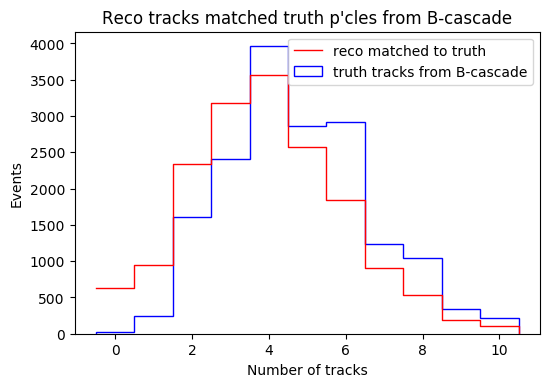

mean number of reco tracks from B-hadron: 3.9926994302


In [21]:
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
plt.hist(nBtrks_inclusive, label='truth tracks from B-cascade', bins=nbins, range=(hmin,hmax), histtype='step', color='b')
rplt.hist(h_ntrks_recoMatchedToTruth,label='reco matched to truth', color='r')
plt.xlabel('Number of tracks')
plt.ylabel('Events')
plt.legend()
plt.title('Reco tracks matched truth p\'cles from B-cascade')
plt.show()

print "mean number of reco tracks from B-hadron: {}".format(h_ntrks_recoMatchedToTruth.GetMean())

Note: I just assumed that that a reco track that was used by the algorithm was truth matched to some SV.

Sanity check: The number of reco tracks is strictly less than the number of truth trks.

Most of the reco trks have an associated truth particle, but not all.

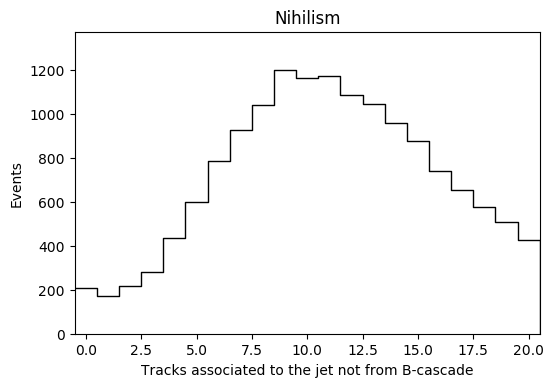

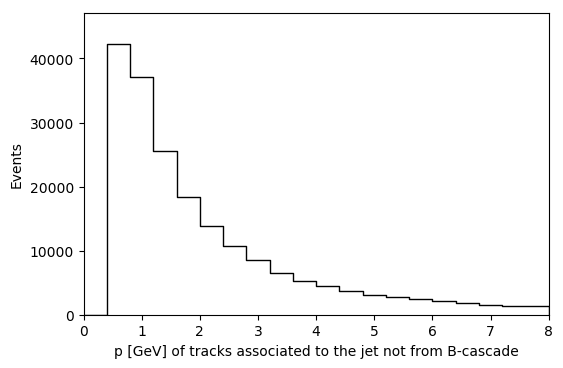

In [22]:
'''
Next: Plot the number of reco tracks that aren't matched to the vtx. in the b-cascade.
'''
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist(h_ntrks_notFromCascade)
plt.xlabel('Tracks associated to the jet not from B-cascade')
plt.ylabel('Events')
plt.title('Nihilism')
plt.show()

fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist(h_p_notFromCascade)
plt.xlabel('p [GeV] of tracks associated to the jet not from B-cascade')
plt.ylabel('Events')
plt.show()


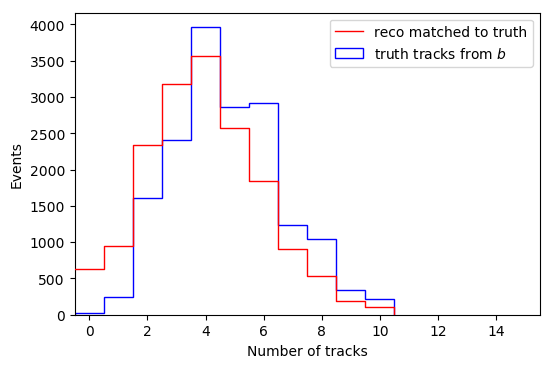

In [23]:
# Draw the histograms
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
plt.hist(nBtrks_inclusive, label='truth tracks from $b$', bins=nbins, range=(hmin,hmax), histtype='step', color='b')
rplt.hist(h_ntrks_recoMatchedToTruth,label='reco matched to truth', color='r')
#rplt.hist(h_ntrks_KEPT, label='tracks selected by algorithm',color='g') 
plt.xlabel('Number of tracks')
plt.ylabel('Events')
plt.legend(loc='best')
#plt.title('Tracks selected for $b$-tagging')
plt.xlim(-0.5, 15.5)
plt.show()

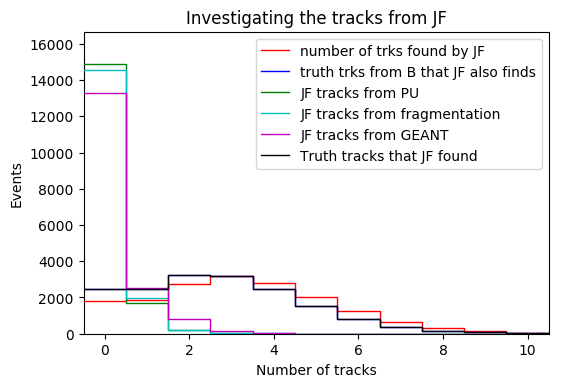

In [24]:
# Combine these into 1 plot to show
# (1) Number of truth tracks
# (2) Number of truth tracks reconstructed
# (3) Number of truth tracks selected by JF

fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist(h_ntrks_JF,label='number of trks found by JF', color='r')
rplt.hist(h_ntrks_KEPT, label='truth trks from B that JF also finds',color='b') 
rplt.hist(h_ntrks_PU, label='JF tracks from PU', color='g')
rplt.hist(h_ntrks_FRAG, label='JF tracks from fragmentation', color='c')
rplt.hist(h_ntrks_GEANT, label='JF tracks from GEANT', color='m')
rplt.hist(h_ntrks_KEPT, label='Truth tracks that JF found', color='k')
plt.xlabel('Number of tracks')
plt.ylabel('Events')
plt.legend()
plt.title('Investigating the tracks from JF')
plt.show()


- It seems like GEANT is the most significant fake track, followed by fragmentation
- PU is the least important, because PU is generally along the beam line, and the IP selections should remove most of it.

Conclusion: Most of the tracks that JF finds correspond to truth particles.

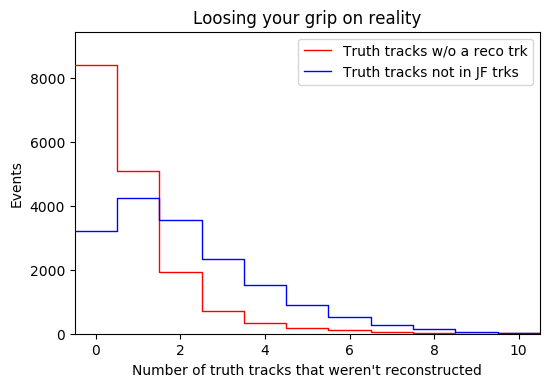

Mean number of truth p'cles lost to reco tracks: 0.884556030389 
Mean number of truth p'cles not found by JF:     2.15432098765 


In [25]:
# Number of truth tracks from B that aren't in reco
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist(h_ntrks_LOST,   label='Truth tracks w/o a reco trk', color='r')
rplt.hist(h_ntrks_LOST_JF,label='Truth tracks not in JF trks', color='b')
plt.xlabel('Number of truth tracks that weren\'t reconstructed')
plt.ylabel('Events')
plt.legend()
plt.title('Loosing your grip on reality')
plt.show()

print "Mean number of truth p'cles lost to reco tracks: {} ".format(h_ntrks_LOST.GetMean())
print "Mean number of truth p'cles not found by JF:     {} ".format(h_ntrks_LOST_JF.GetMean())

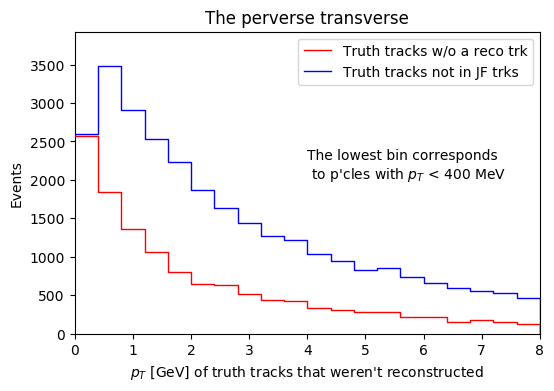

In [26]:
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
ax = fig.add_subplot(111)
rplt.hist(h_LOSTtrks_pT,   label='Truth tracks w/o a reco trk', color='r')
rplt.hist(h_LOSTtrks_pT_JF,label='Truth tracks not in JF trks', color='b')
plt.xlabel('$p_T$ [GeV] of truth tracks that weren\'t reconstructed')
plt.ylabel('Events')
plt.legend()
ax.text(4, 2000, 'The lowest bin corresponds\n to p\'cles with $p_T$ < 400 MeV')
plt.title('The perverse transverse')
plt.show()

There's a pedestal at 400 MeV for truth particles that were reconstructed in reco, which makes sense since we don't have detector resolution that low anyways. I feel like it's kind of wierd / unoptimal that the JF pT dist doesn't peak at the lowest pT bin.

B/c MS

# Calculating a couple numbers

(4) Given all truth particles, how many have tracks?

(5) Given we have a track from a vertex, how many do we miss from JF?

Notes: The truth level info is in BHadronBranches.cxx.

In [27]:
'''
Trying to answer question (4): Given all truth particles, how many have tracks?
I'm going to consider the truth particles from the b-hadron, and just do a pdg match.
So repeat the cell above, but over the whole Ntuple

Also looking at how many jets have lost at least one track, defined from the pdg match?

'''
n_truth = 0
n_trk_pdg_matched = 0
n_trk_barcode_matched = 0

n_jets = 0
n_jetsWithOneLostTrack = 0

for (_,(jet_child_pdg,jet_child_barcode,jet_trk_pdg,jet_trk_barcode)) in df[['jet_bH_child_pdg_id','jet_bH_child_barcode','jet_trk_pdg_id','jet_trk_barcode']].iterrows():
  
    for child_pdgs,child_barcodes,trk_pdgs,trk_barcodes in zip(jet_child_pdg,jet_child_barcode,jet_trk_pdg,jet_trk_barcode):
        # Only continue if this jet had an associated b or c-hadron
        if child_pdgs.size > 0 and child_pdgs[0] != -99:
            
            child_pdgs =  child_pdgs.tolist()
            n_truth = n_truth + len(child_pdgs)
            n_jets = n_jets + 1
            
            for pdg,barcode in zip(trk_pdgs,trk_barcodes):
                if pdg in child_pdgs:
                    n_trk_pdg_matched = n_trk_pdg_matched + 1
                    child_pdgs.remove(pdg)
                if barcode in child_barcodes:
                    n_trk_barcode_matched = n_trk_barcode_matched + 1
            
            if len(child_pdgs) != 0:
                n_jetsWithOneLostTrack = n_jetsWithOneLostTrack +1
            
print "{0} truth particles, {1} pdg matched to reco, {2} barcode matched to reco".format(n_truth,n_trk_pdg_matched,n_trk_barcode_matched)
print "{}% pdg matched".format(100.*n_trk_pdg_matched/n_truth)
print "{}% barcode matched".format(100.*n_trk_barcode_matched/n_truth)

print "\n{0} of the {1} b or c-jets had lost at least one track (defined from the pdg match)".format(n_jetsWithOneLostTrack,n_jets)

82041 truth particles, 74597 pdg matched to reco, 67269 barcode matched to reco
90.9264879755% pdg matched
81.9943686693% barcode matched

4321 of the 16822 b or c-jets had lost at least one track (defined from the pdg match)


The pdg match is not a good measure of the higher efficiency, so it isn't surprising that the efficiency defined this way is higher than the barcode match.

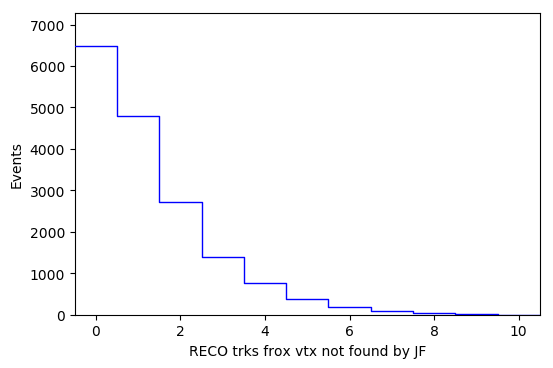

Avg # of tracks lost by JF: 1.27706552707


In [28]:
'''
How many reco tracks associated to the B-cascade by some alg does JF lose?
'''
fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist(h_RECOtrks_LOST_JF,color='b')
plt.xlabel('RECO trks frox vtx not found by JF')
plt.ylabel('Events')
plt.show()

print "Avg # of tracks lost by JF: {}".format(h_RECOtrks_LOST_JF.GetMean())

h_ntrks_vs_jpt entries = 16848.0


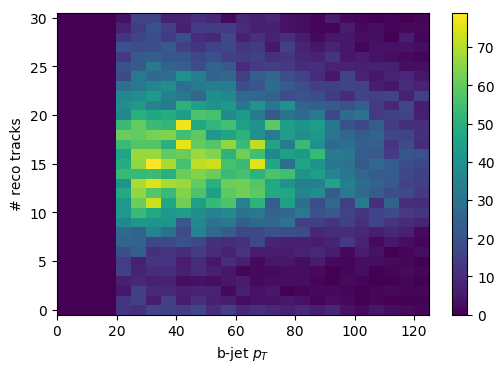

In [29]:
'''
Number of tracks as a function of jet pt 
'''
print "h_ntrks_vs_jpt entries = {}".format(h_ntrks_vs_jpt.GetEntries())
# plot_2D(h_ntrks_vs_jpt,xlabel="b-jet $p_T$ [GeV]",ylabel="Number of reco tracks")

fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
rplt.hist2d(h_ntrks_vs_jpt)#, norm=LogNorm())
im = rplt.imshow(h_ntrks_vs_jpt)
fig.colorbar(im)
plt.xlabel("b-jet $p_T$")
plt.ylabel("# reco tracks")
plt.show()

- All of the jets have a $p_T$ cut of 20 GeV applied.
- In general, there are quite a few reco tracks, almost 3x as many as the expected 5 from the b-cascade
- There doesn't really seem to be a dependence on the # of reco tracks with the jet's pT, because this is an invariant in QCD.